# Library import

In [2]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
from functions import *

# Model Training

In [4]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "../data/train"
traindata_info_file = "../data/train.csv"
save_result_path = "../train_result"

In [7]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

# 총 class의 수를 측정.
num_classes = len(train_info['target'].unique())

# 각 class별로 8:2의 비율이 되도록 학습과 검증 데이터를 분리.
train_df, val_df = train_test_split(
    train_info, 
    test_size=0.2,
    stratify=train_info['target']
)

In [8]:
# 학습에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
train_transform = transform_selector.get_transform(is_train=True)
val_transform = transform_selector.get_transform(is_train=False)

# 학습에 사용할 Dataset을 선언.
train_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=train_df,
    transform=train_transform
)
val_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=val_df,
    transform=val_transform
)

# 학습에 사용할 DataLoader를 선언.
train_loader = DataLoader(
    train_dataset, 
    batch_size=128, 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=128, 
    shuffle=False
)

In [9]:
# 학습에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='resnet101', 
    pretrained=True
)
model = model_selector.get_model()

# 선언된 모델을 학습에 사용할 장비로 셋팅.
model.to(device)

TimmModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

In [10]:
# 학습에 사용할 optimizer를 선언하고, learning rate를 지정
optimizer = optim.Adam(
    model.parameters(), 
    lr=0.001
)

In [11]:
# 스케줄러 초기화
scheduler_step_size = 30  # 매 30step마다 학습률 감소
scheduler_gamma = 0.1  # 학습률을 현재의 10%로 감소

# 한 epoch당 step 수 계산
steps_per_epoch = len(train_loader)

# 2 epoch마다 학습률을 감소시키는 스케줄러 선언
epochs_per_lr_decay = 2
scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=scheduler_step_size, 
    gamma=scheduler_gamma
)

In [12]:
# 학습에 사용할 Loss를 선언.
loss_fn = Loss()

In [15]:
# 앞서 선언한 필요 class와 변수들을 조합해, 학습을 진행할 Trainer를 선언. 
trainer = Trainer(
    model=model, 
    device=device, 
    train_loader=train_loader,
    val_loader=val_loader, 
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn, 
    epochs=30,
    result_path=save_result_path
)

Epoch 1/30


Epoch 1, Train Loss: 3.3937, Train Accuracy: 0.3500
Epoch 1, Validation Loss: 1.4790, Validation Accuracy: 0.6220

Save 0epoch result. Loss = 1.4790
Lowest loss updated to 1.4790. Early stop counter reset to 0.


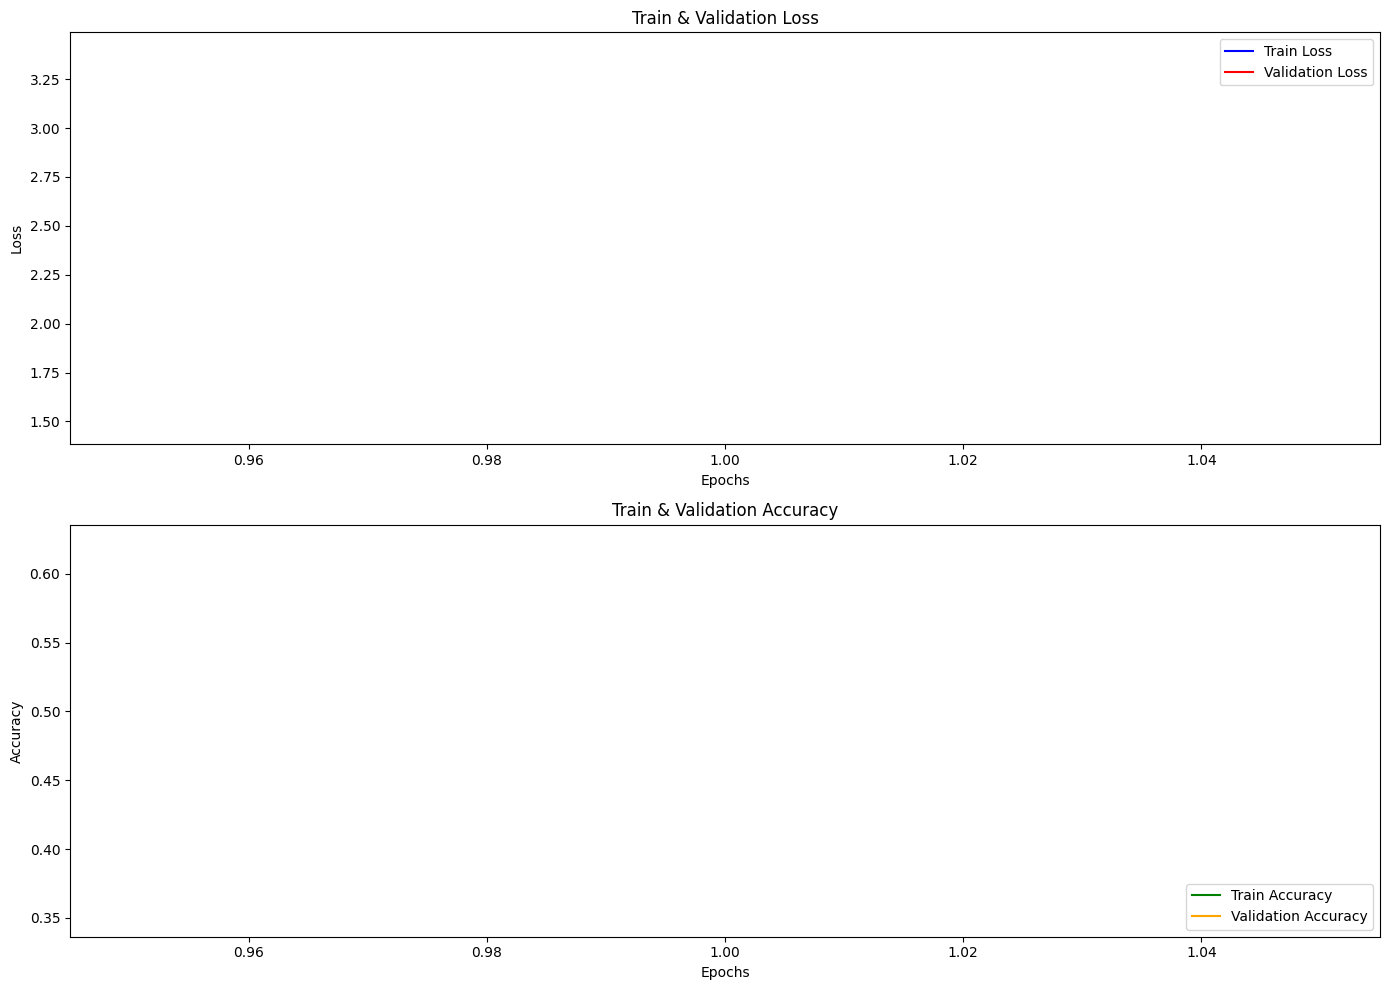

Epoch 2/30


Epoch 2, Train Loss: 1.1371, Train Accuracy: 0.6916
Epoch 2, Validation Loss: 1.1208, Validation Accuracy: 0.7022

Save 1epoch result. Loss = 1.1208
Lowest loss updated to 1.1208. Early stop counter reset to 0.


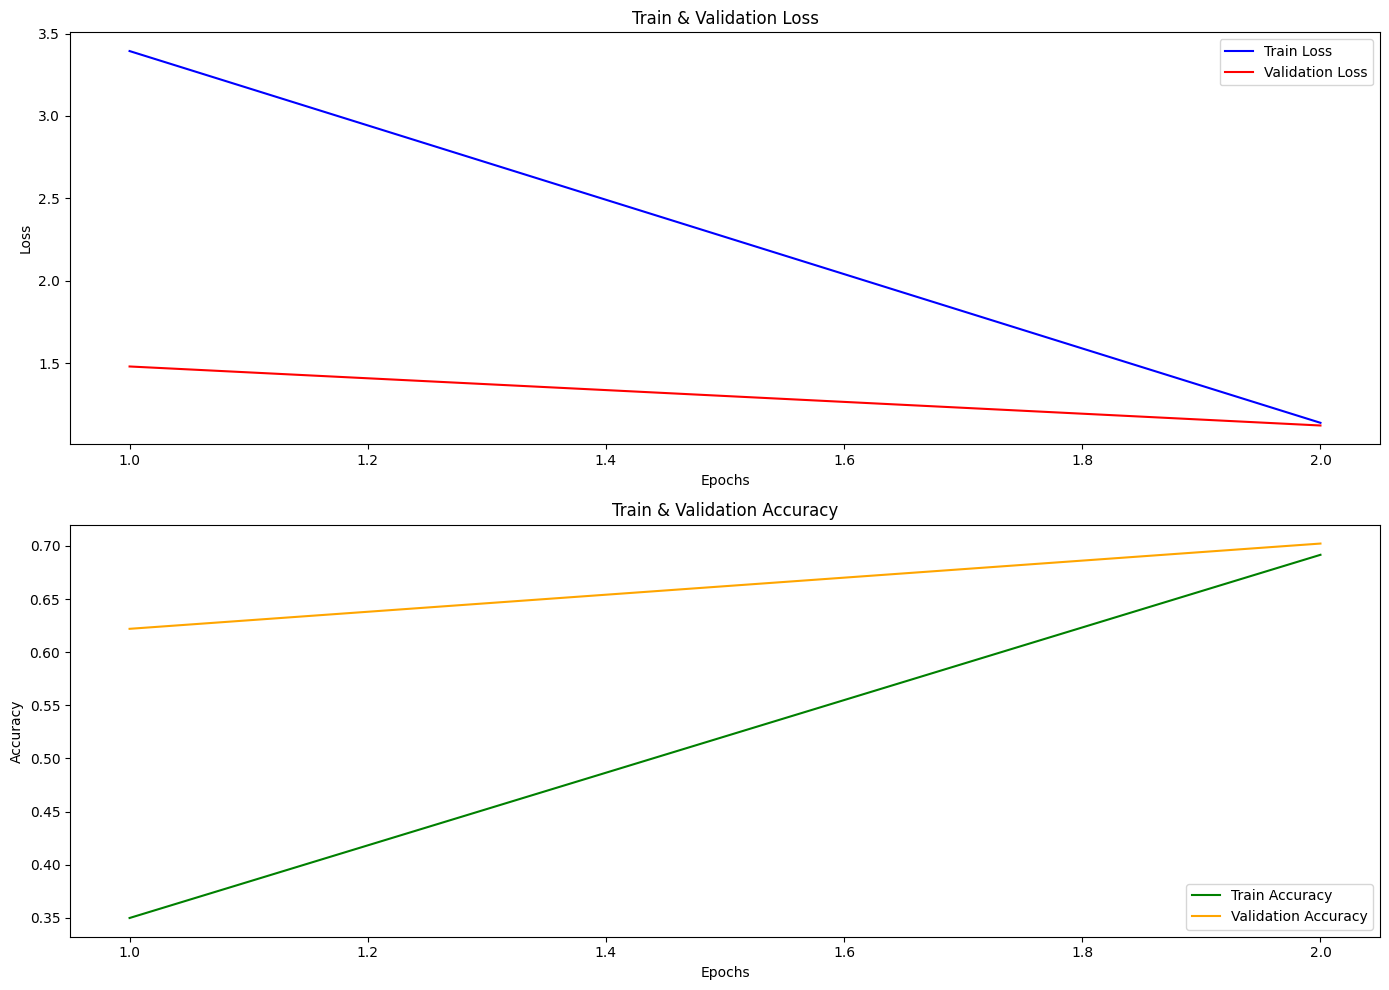

Epoch 3/30


Epoch 3, Train Loss: 0.7051, Train Accuracy: 0.7987
Epoch 3, Validation Loss: 1.0067, Validation Accuracy: 0.7318

Save 2epoch result. Loss = 1.0067
Lowest loss updated to 1.0067. Early stop counter reset to 0.


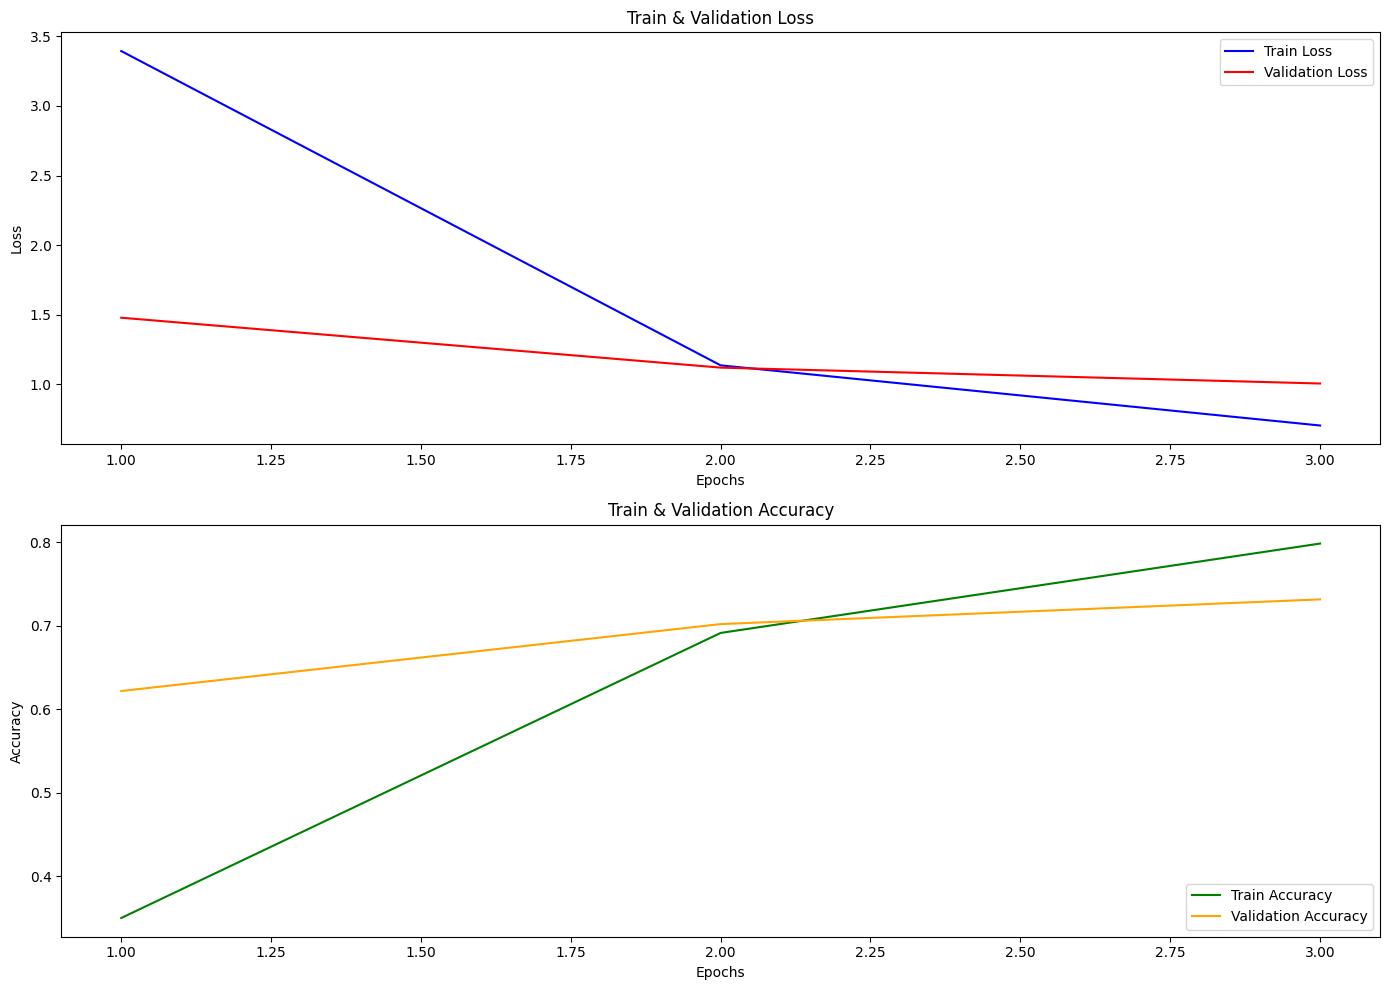

Epoch 4/30


Epoch 4, Train Loss: 0.5046, Train Accuracy: 0.8490
Epoch 4, Validation Loss: 0.9917, Validation Accuracy: 0.7374

Save 3epoch result. Loss = 0.9917
Lowest loss updated to 0.9917. Early stop counter reset to 0.


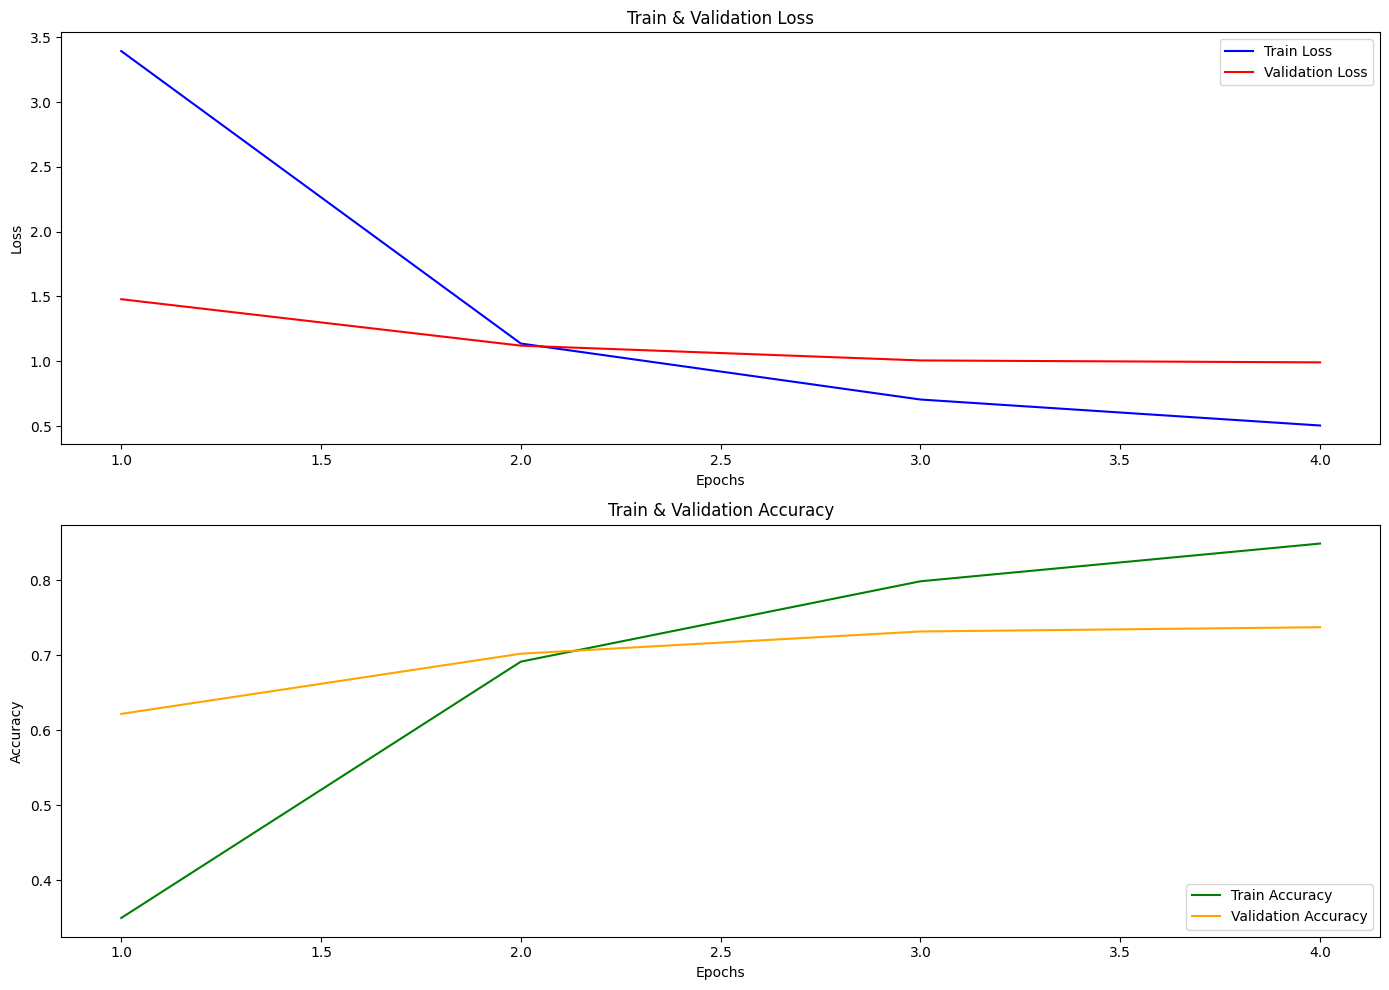

Epoch 5/30


Epoch 5, Train Loss: 0.4123, Train Accuracy: 0.8752
Epoch 5, Validation Loss: 0.9757, Validation Accuracy: 0.7551

Save 4epoch result. Loss = 0.9757
Lowest loss updated to 0.9757. Early stop counter reset to 0.


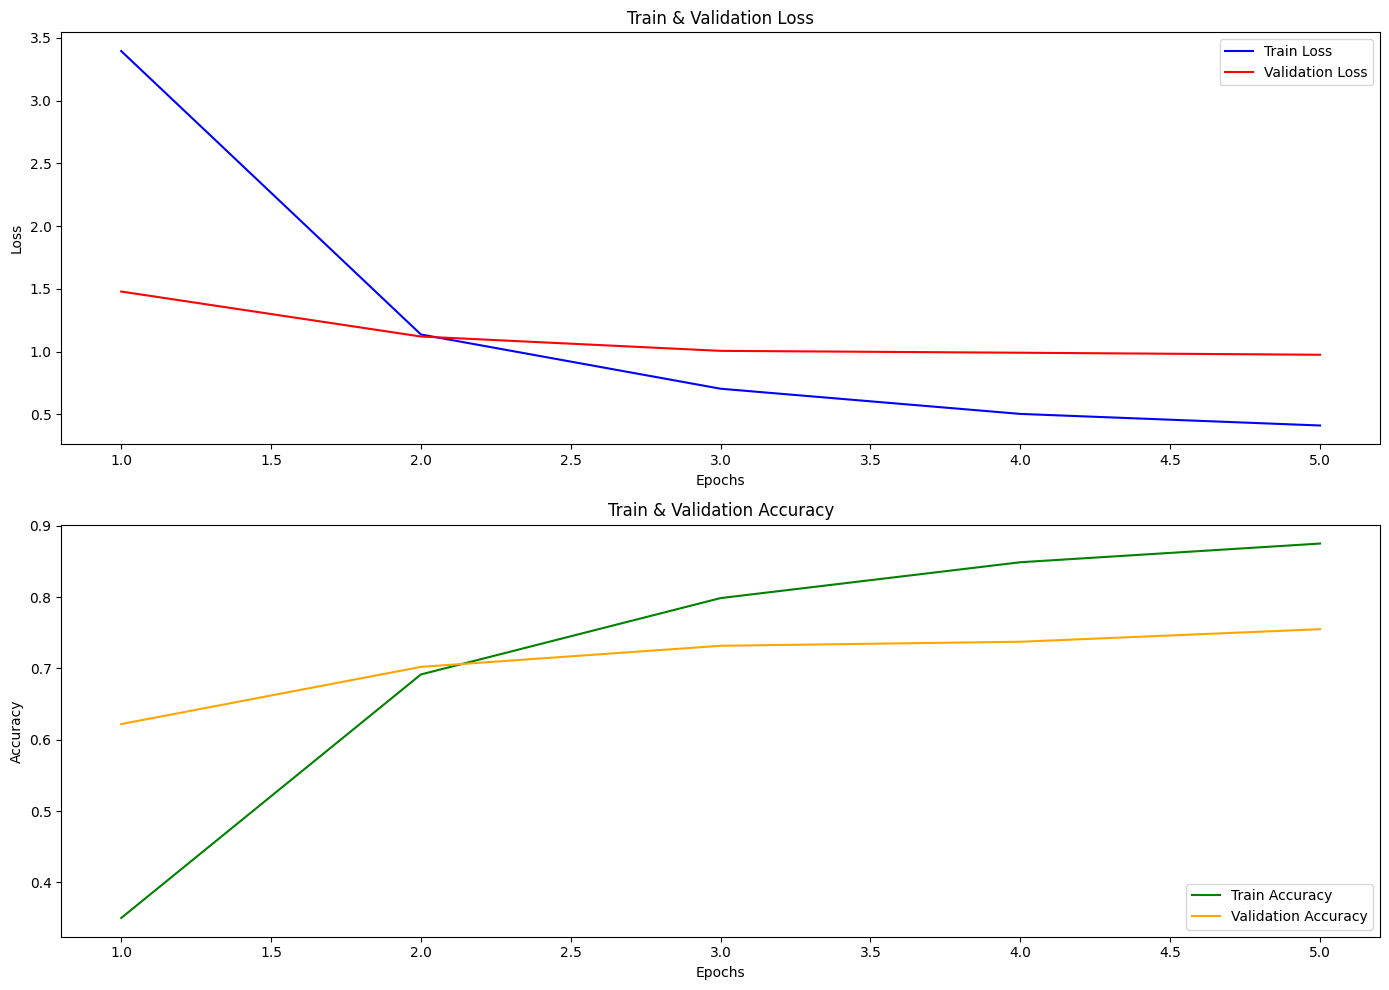

Epoch 6/30


Epoch 6, Train Loss: 0.3397, Train Accuracy: 0.8987
Epoch 6, Validation Loss: 0.9474, Validation Accuracy: 0.7664

Save 5epoch result. Loss = 0.9474
Lowest loss updated to 0.9474. Early stop counter reset to 0.


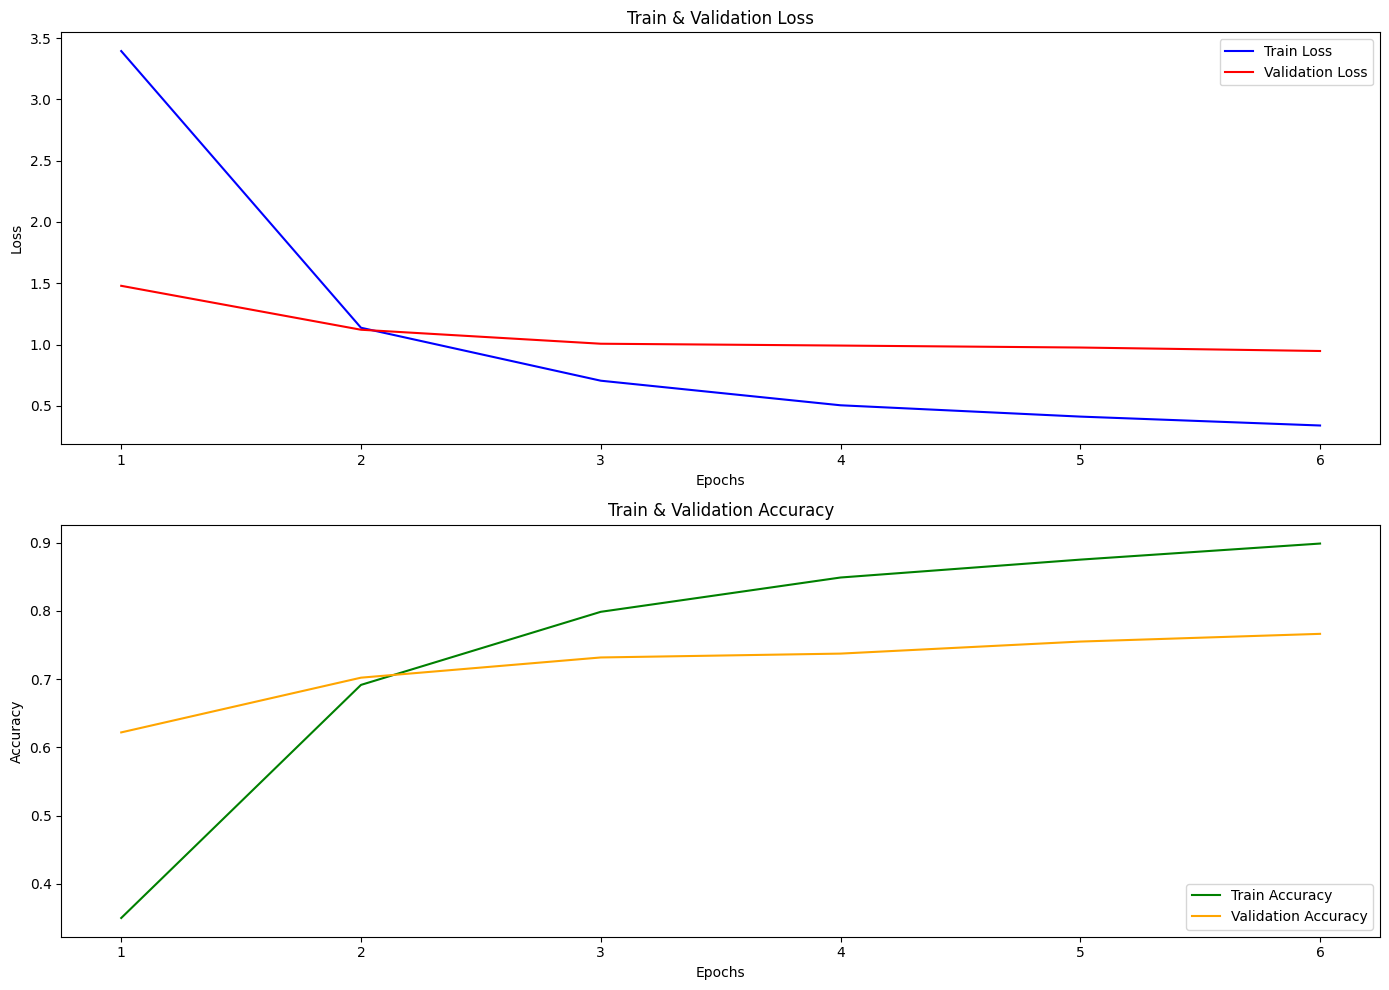

Epoch 7/30


Epoch 7, Train Loss: 0.2906, Train Accuracy: 0.9124
Epoch 7, Validation Loss: 0.9632, Validation Accuracy: 0.7824



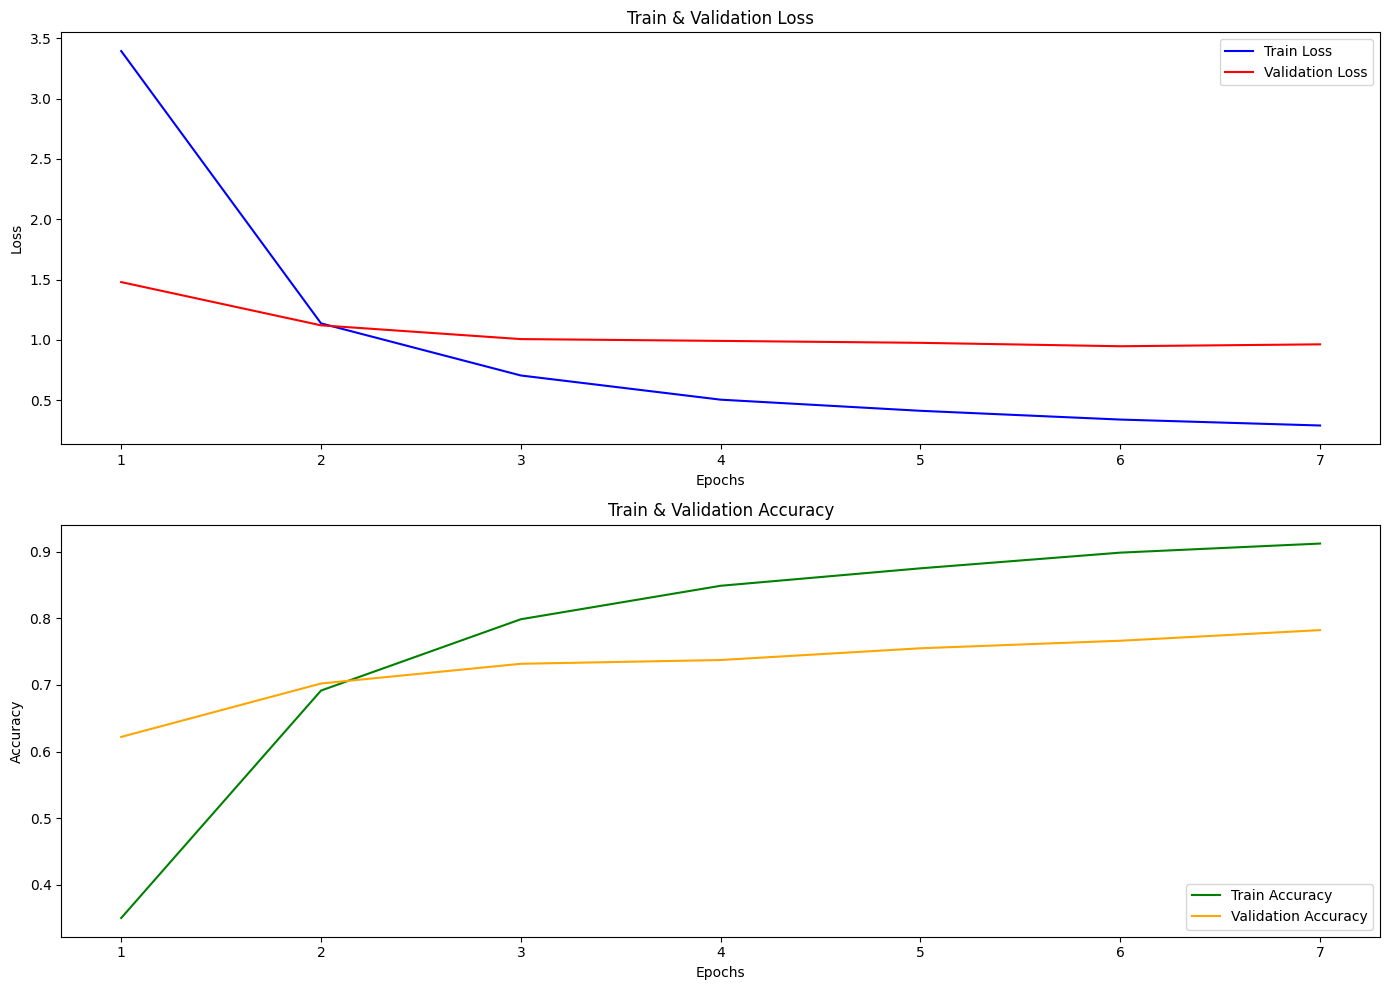

Epoch 8/30


Epoch 8, Train Loss: 0.2640, Train Accuracy: 0.9209
Epoch 8, Validation Loss: 0.9715, Validation Accuracy: 0.7780



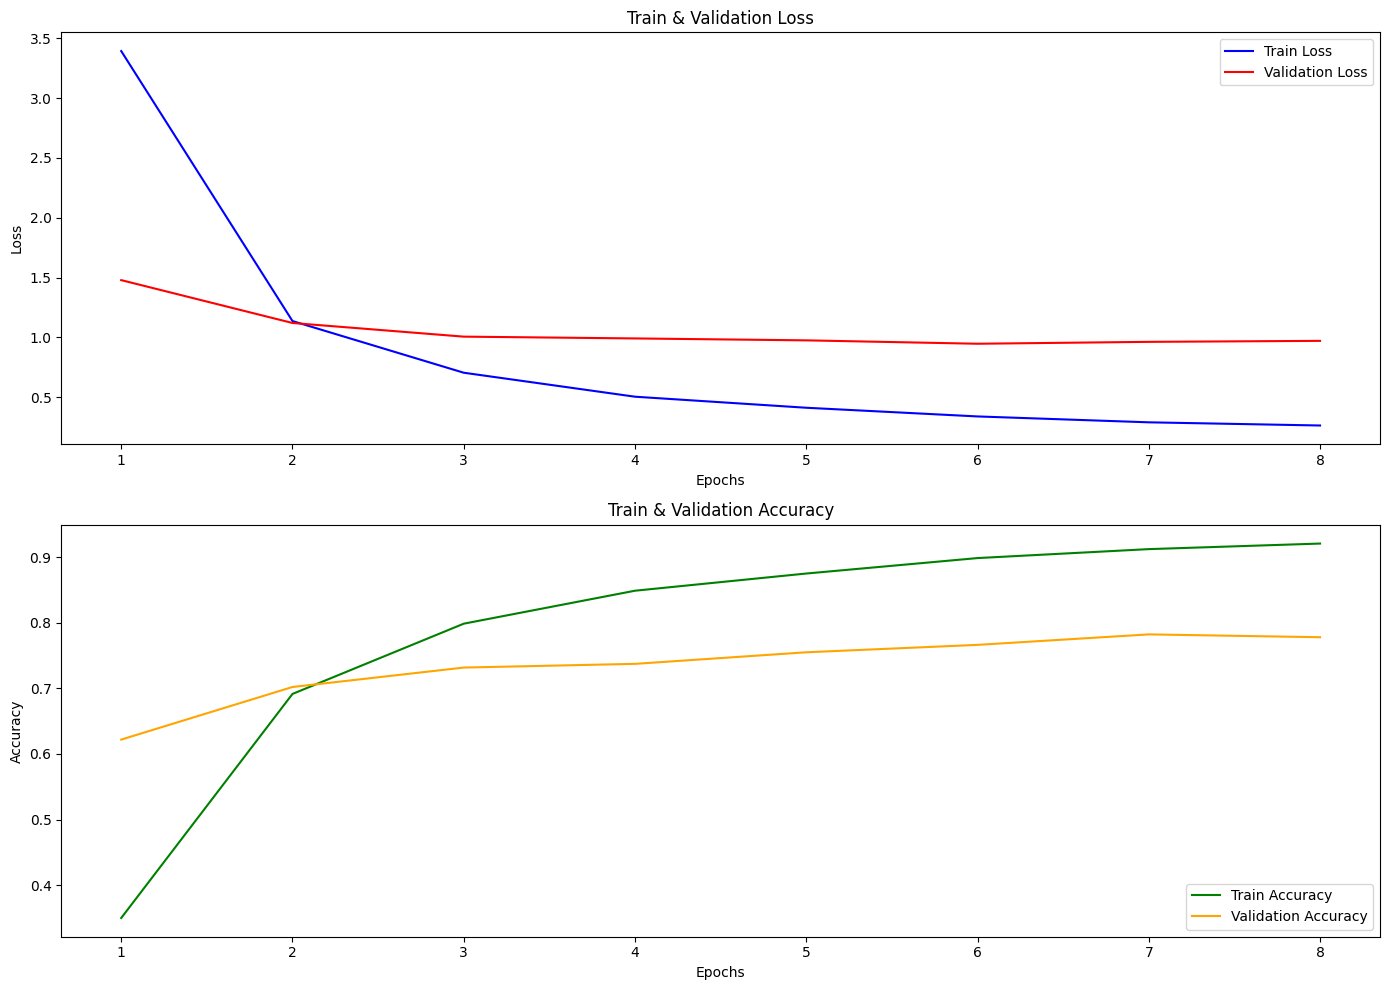

Epoch 9/30


Epoch 9, Train Loss: 0.2150, Train Accuracy: 0.9360
Epoch 9, Validation Loss: 0.9616, Validation Accuracy: 0.7681



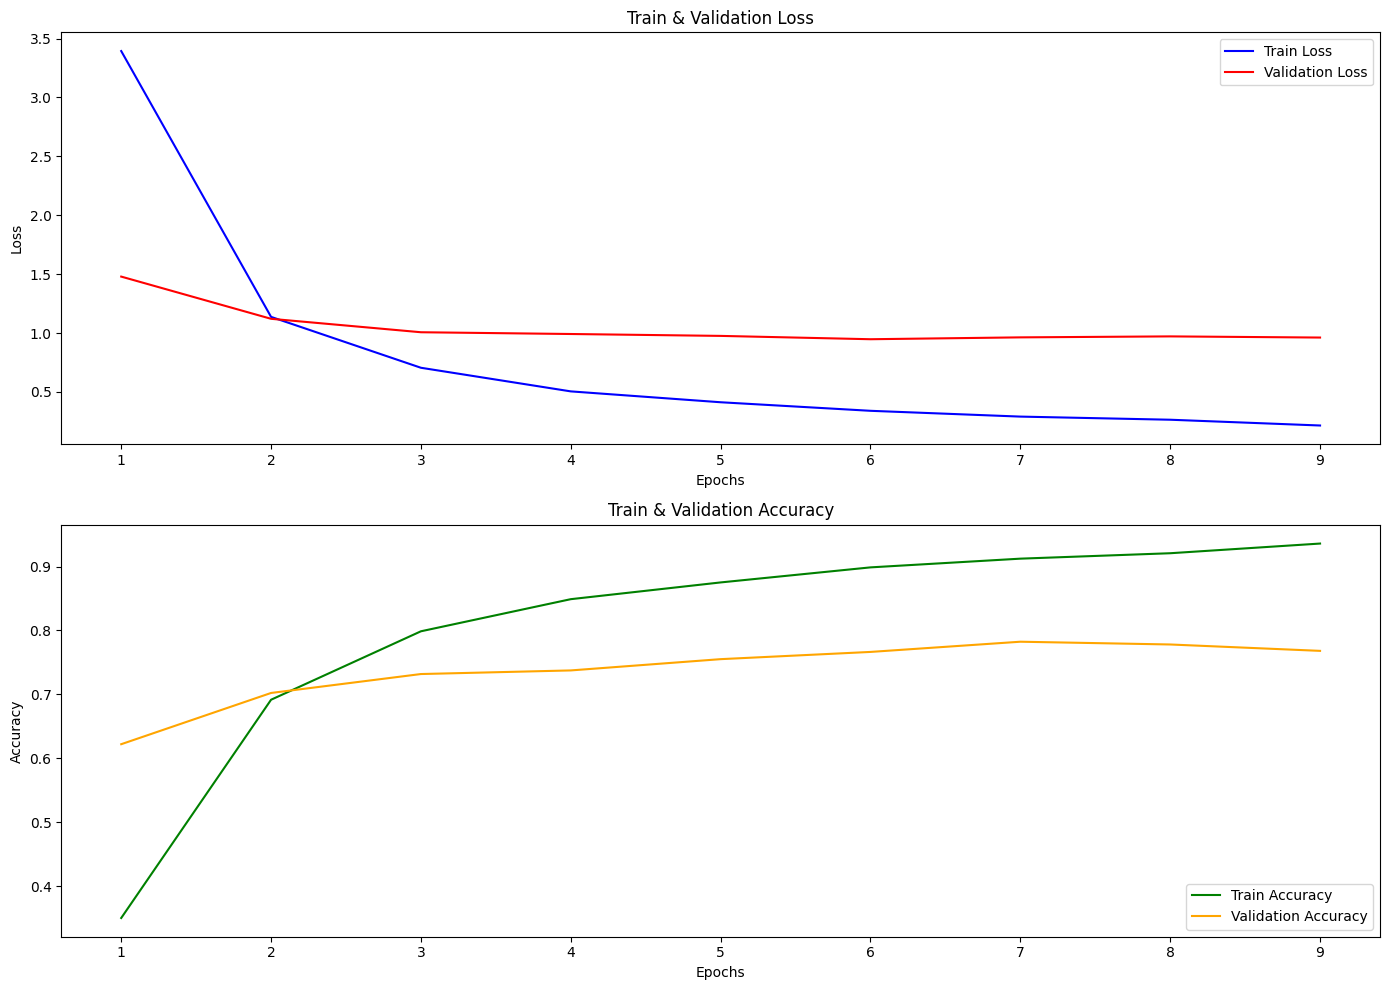

Epoch 10/30


Epoch 10, Train Loss: 0.2127, Train Accuracy: 0.9391
Epoch 10, Validation Loss: 0.9812, Validation Accuracy: 0.7870



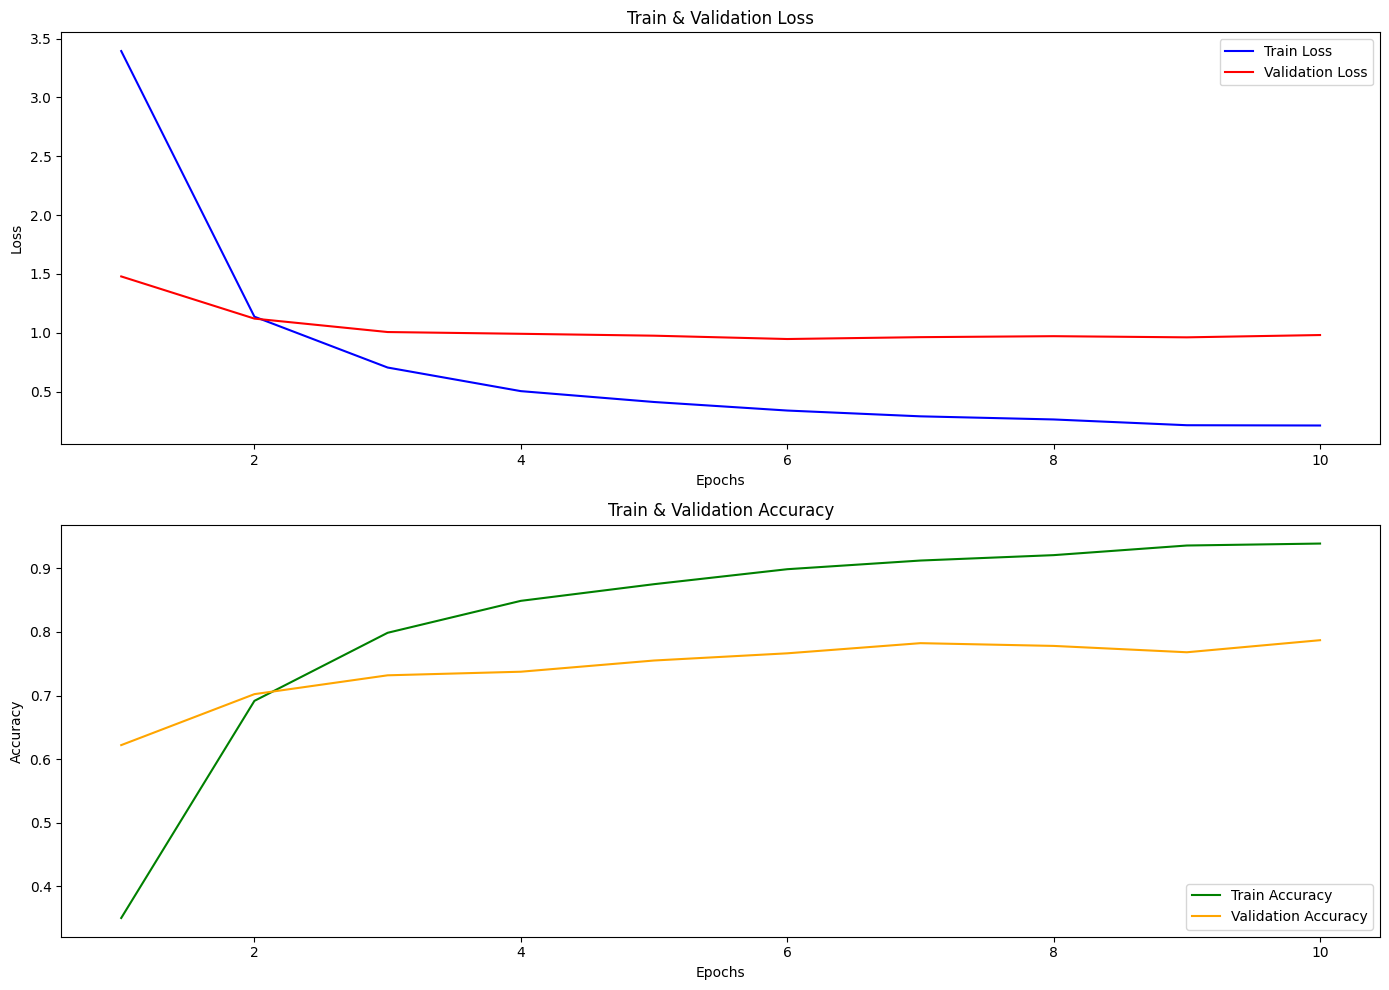

Epoch 11/30


Epoch 11, Train Loss: 0.1893, Train Accuracy: 0.9446
Epoch 11, Validation Loss: 0.9319, Validation Accuracy: 0.7903

Save 10epoch result. Loss = 0.9319
Lowest loss updated to 0.9319. Early stop counter reset to 0.


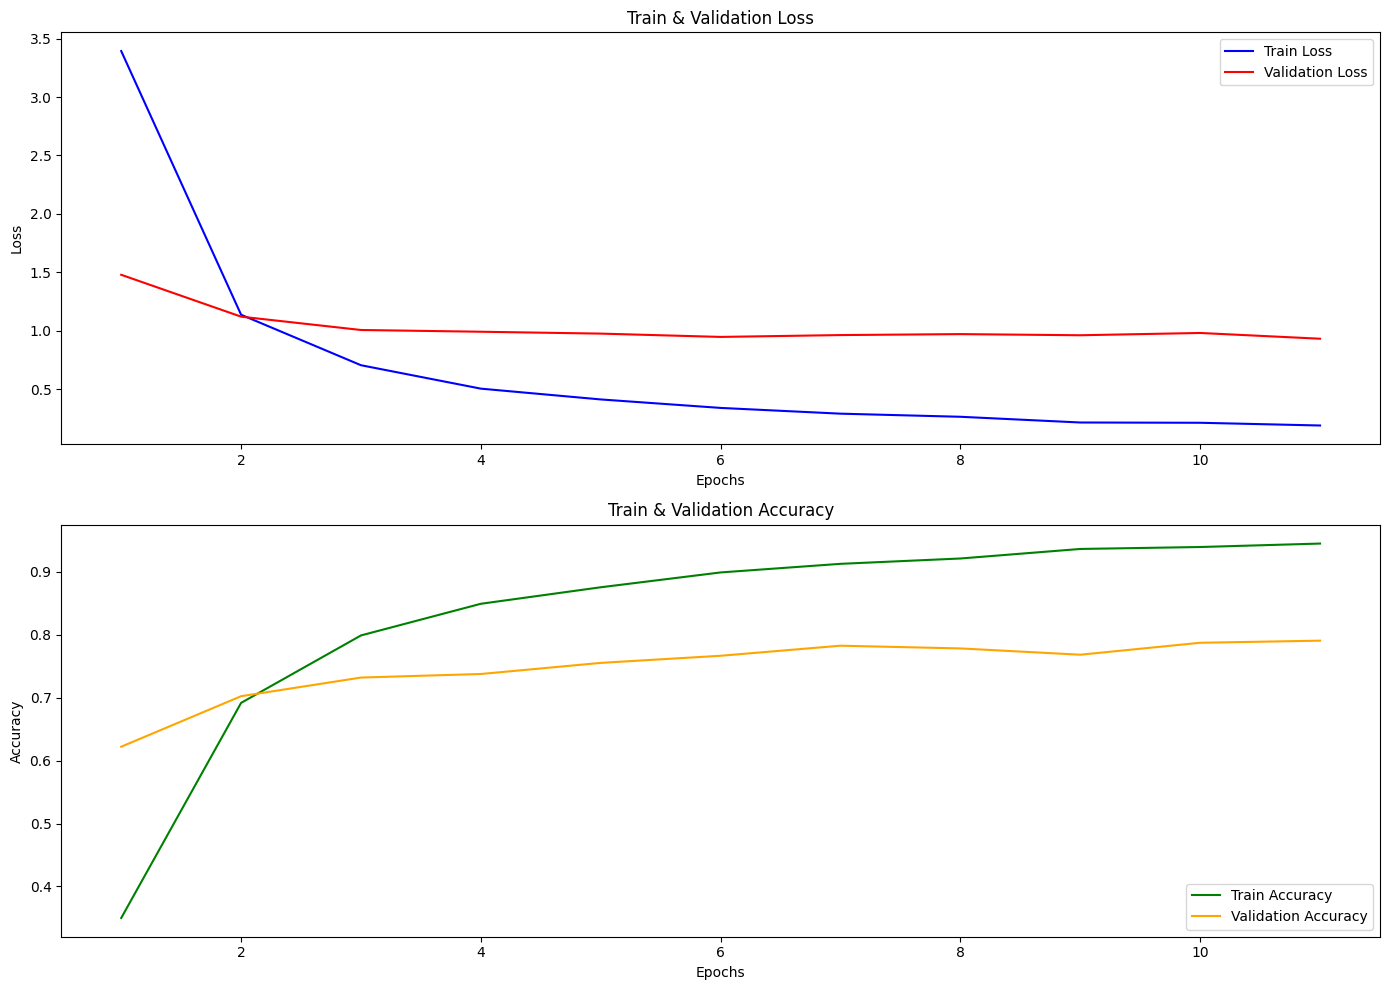

Epoch 12/30


Epoch 12, Train Loss: 0.1775, Train Accuracy: 0.9461
Epoch 12, Validation Loss: 0.9817, Validation Accuracy: 0.7884



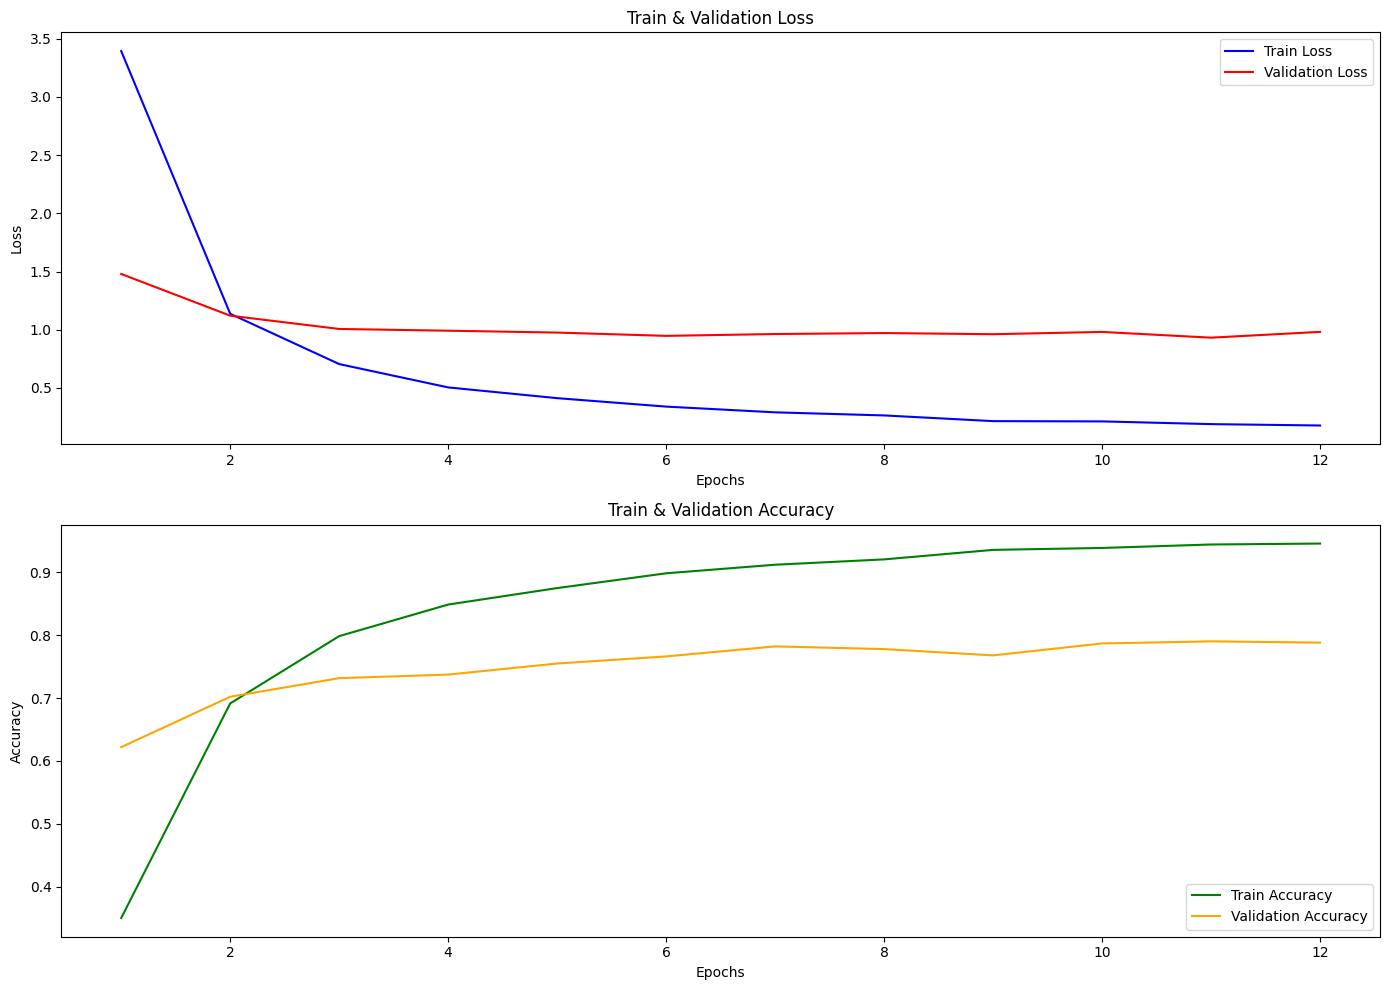

Epoch 13/30


KeyboardInterrupt: 

In [16]:
# 모델 학습.
trainer.train()

# Inference

In [10]:
# 모델 추론을 위한 함수
def inference(
    model: nn.Module, 
    device: torch.device, 
    test_loader: DataLoader
):
    # 모델을 평가 모드로 설정
    model.to(device)
    model.eval()
    
    predictions = []
    with torch.no_grad():  # Gradient 계산을 비활성화
        for images in tqdm(test_loader):
            # 데이터를 같은 장치로 이동
            images = images.to(device)
            
            # 모델을 통해 예측 수행
            logits = model(images)
            logits = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            
            # 예측 결과 저장
            predictions.extend(preds.cpu().detach().numpy())  # 결과를 CPU로 옮기고 리스트에 추가
    
    return predictions

In [11]:
# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"
save_result_path = "./train_result"

In [12]:
# 추론 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
test_info = pd.read_csv(testdata_info_file)

# 총 class 수.
num_classes = 500

In [13]:
# 추론에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
test_transform = transform_selector.get_transform(is_train=False)

# 추론에 사용할 Dataset을 선언.
test_dataset = CustomDataset(
    root_dir=testdata_dir,
    info_df=test_info,
    transform=test_transform,
    is_inference=True
)

# 추론에 사용할 DataLoader를 선언.
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False,
    drop_last=False
)

In [14]:
# 추론에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 추론에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='resnet101', 
    pretrained=False
)
model = model_selector.get_model()


In [15]:
# best epoch 모델을 불러오기.
model.load_state_dict(
    torch.load(
        os.path.join(save_result_path, "best_model.pt"),
        map_location='cpu'
    )
)

C:\Users\zin\AppData\Local\Temp\ipykernel_11588\1021875342.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [16]:
# predictions를 CSV에 저장할 때 형식을 맞춰서 저장
# 테스트 함수 호출
predictions = inference(
    model=model, 
    device=device, 
    test_loader=test_loader
)

  0%|          | 0/157 [00:00<?, ?it/s]

In [17]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info['target'] = predictions
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,image_path,target
0,0,0.JPEG,328
1,1,1.JPEG,414
2,2,2.JPEG,493
3,3,3.JPEG,17
4,4,4.JPEG,388
...,...,...,...
10009,10009,10009.JPEG,235
10010,10010,10010.JPEG,107
10011,10011,10011.JPEG,329
10012,10012,10012.JPEG,322


In [18]:
# DataFrame 저장
test_info.to_csv("output101.csv", index=False)